<h1><center>EE69210: Machine Learning for Signal Processing Laboratory</center></h1>
<h2><center>Experiment-2: Lossless Compression</center></h2>
<h3><center>Anirvan Krishna | 21EE38002</center></h3>

# Dataset-1

## Data Generation

In [417]:
import random
import string
import numpy as np
import sys
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import struct
from bitarray import bitarray
import time

In [418]:
def generate_random_string(N):

    # Define the characters to choose from (lowercase letters and numbers)
    characters = string.ascii_lowercase + string.digits
    
    # Generate random string
    random_string = ''.join(random.choice(characters) for _ in range(N))
    
    return random_string

In [419]:
N = [50]

for n in N:
    for t in range(1):
        # Generate random string
        random_text = generate_random_string(n)

        # Write the random string to a file
        with open(f"string.txt", "w") as file:
            file.write(random_text)

## Encoder Design

In [420]:
with open(f"string.txt", "r") as file:
    X = file.read()

In [421]:
def find_symbol_probability(symbols, X):
    symbol_prob = {}
    for symbol in symbols:
        symbol_prob[symbol] = X.count(symbol) / len(X)
    return symbol_prob

In [422]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_dict):
    # Convert dictionary into a list of HuffmanNodes
    min_heap = [HuffmanNode(symbol, freq)
                for symbol, freq in freq_dict.items()]

    # Convert list into a heap (priority queue)
    heapq.heapify(min_heap)

    while len(min_heap) > 1:
        # Extract two nodes with the lowest frequency
        left = heapq.heappop(min_heap)
        right = heapq.heappop(min_heap)

        # Create a new internal node with the combined frequency
        new_node = HuffmanNode(None, left.freq + right.freq)
        new_node.left = left
        new_node.right = right

        # Push the new node back into the heap
        heapq.heappush(min_heap, new_node)

    # The last remaining node is the root of the Huffman tree
    return min_heap[0]

In [423]:
def encode_tree(node):
    """
    For each node, starting at root:

    If leaf-node: Output 1-bit + N-bit character/byte
    If not leaf-node, output 0-bit. Then encode both child nodes (left first then right) the same way
    """

    if node is None:
        return bitarray()

    bits = bitarray()

    if node.symbol is not None:
        bits.append(True)  # Leaf node
        bits.frombytes(node.symbol.encode('latin-1'))
    else:
        bits.append(False)  # Internal node
        bits += encode_tree(node.left)
        bits += encode_tree(node.right)

    return bits

def decode_tree(bits, index):
    """
    Read bit. If 1, then read N-bit character/byte, return new node around it with no children
    If bit was 0, decode left and right child-nodes the same way, and return new node around them with those children, but no value
    """

    if bits[index]:
        # Leaf node
        index += 1
        symbol = bits[index:index + 8].tobytes().decode('latin-1')
        index += 8
        return HuffmanNode(symbol, 0), index

    # Internal node
    index += 1
    left, index = decode_tree(bits, index)
    right, index = decode_tree(bits, index)
    node = HuffmanNode(None, 0)
    node.left = left
    node.right = right
    return node, index

def build_huffman_codes(node, current_code, codes):
    """
    Traverse the Huffman tree and build the codes for each symbol.
    
    :param node: Current node in the Huffman tree.
    :param current_code: The current Huffman code being built.
    :param codes: A dictionary to store the symbol-code pairs.
    """
    if node is None:
        return

    # If the node is a leaf node (contains a symbol), store its code
    if node.symbol is not None:
        codes[node.symbol] = current_code
        return

    # Traverse left (append '0' to the current code)
    build_huffman_codes(node.left, current_code + '0', codes)
    # Traverse right (append '1' to the current code)
    build_huffman_codes(node.right, current_code + '1', codes)

def get_huffman_codes(root):
    """
    Generate Huffman codes for all symbols in the tree.
    
    :param root: The root of the Huffman tree.
    :return: A dictionary mapping symbols to their Huffman codes.
    """
    codes = {}
    build_huffman_codes(root, "", codes)
    return codes

In [424]:
symbols_X = set(X)
symbols_X = list(symbols_X)

symbol_prob = find_symbol_probability(symbols_X, X)
symbol_prob = dict(sorted(symbol_prob.items(), key=lambda x: x[1], reverse=True))

huffman_root = build_huffman_tree(symbol_prob)

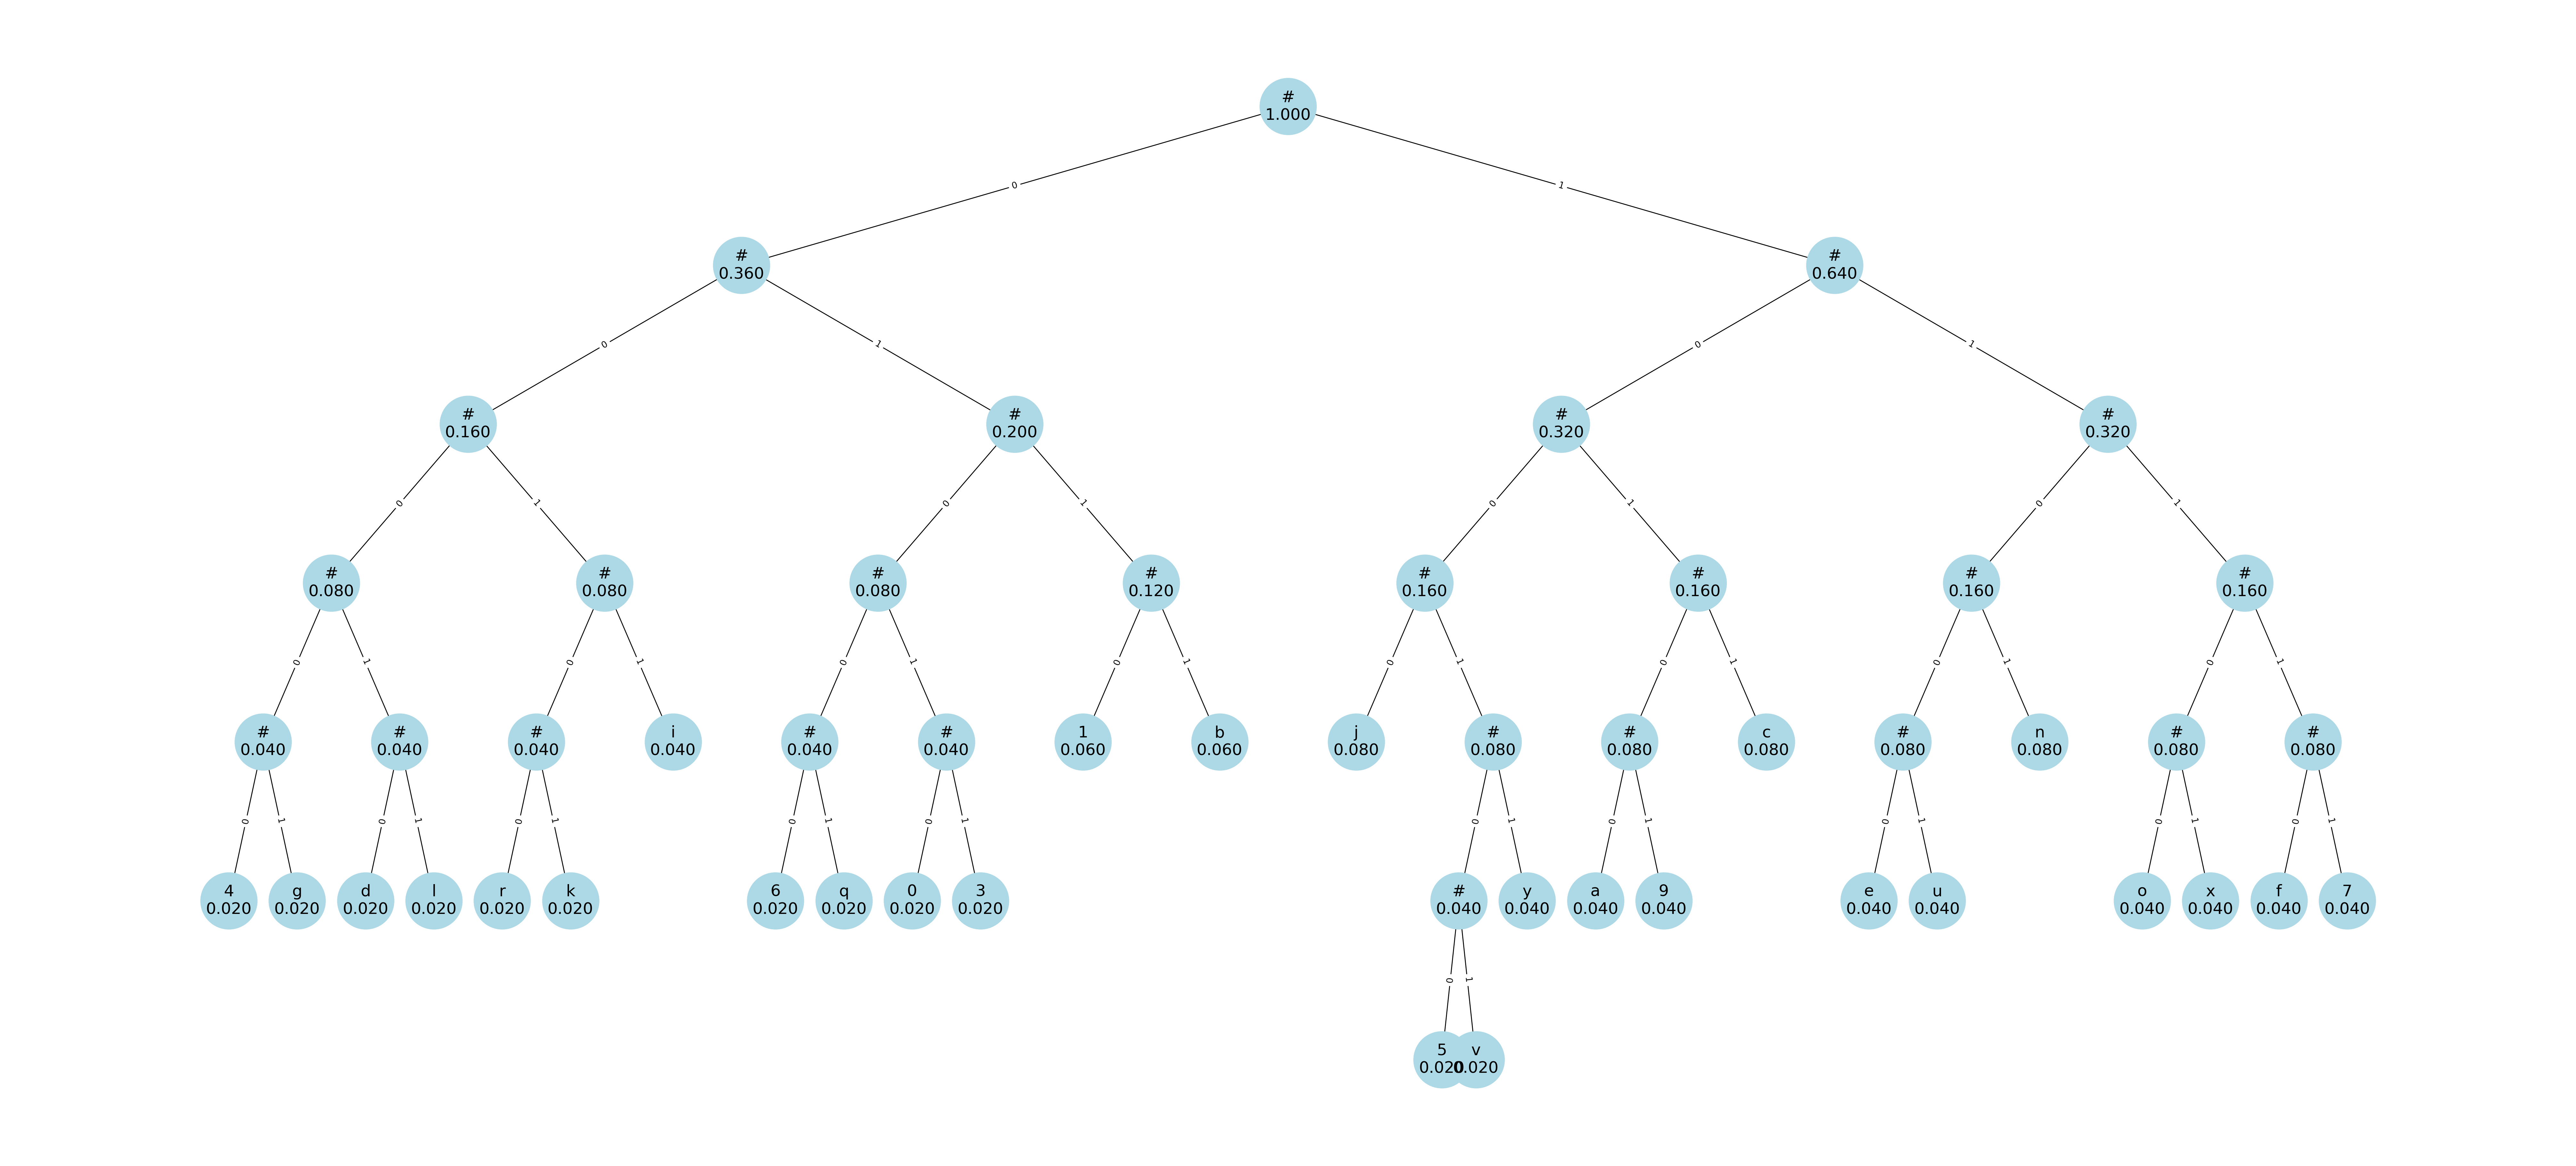

In [425]:
def create_huffman_graph(node, G=None, pos=None, level=0, offset=0, width=2):
    if G is None:
        G = nx.Graph()
        pos = {}
    
    # Create unique node identifier
    node_id = len(G)
    
    # Add node to graph
    if node.symbol is not None:
        # Leaf node: show symbol and frequency
        label = f"{node.symbol}\n{node.freq:.3f}"
    else:
        # Internal node: show only frequency
        label = f"#\n{node.freq:.3f}"
    
    G.add_node(node_id, label=label)
    pos[node_id] = (offset, -level)
    
    if node.left:
        left_id = len(G)
        left_offset = offset - width / (2 ** level)
        create_huffman_graph(node.left, G, pos, level + 1, left_offset, width)
        G.add_edge(node_id, left_id, label='0')
        
    if node.right:
        right_id = len(G)
        right_offset = offset + width / (2 ** level)
        create_huffman_graph(node.right, G, pos, level + 1, right_offset, width)
        G.add_edge(node_id, right_id, label='1')
    
    return G, pos

# Create graph
G, pos = create_huffman_graph(huffman_root)

# Create figure
plt.figure(figsize=(40, 18), dpi=200)

# Draw graph
nx.draw(G, pos, with_labels=True, 
        labels={node: G.nodes[node]['label'] for node in G.nodes()},
        node_color='lightblue', 
        node_size=4000,
        edge_color='black',
        font_size=18)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 
                                     'label',
                                     )
nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels)

# plt.title('Huffman Tree', fontsize=35)
plt.axis('off')
plt.show()

In [426]:
def Encoder(text, file_path="compressed_file.huf"):
    """
    Encodes text using Huffman coding and saves to a compressed file.

    This function takes a text string, generates a Huffman tree, and creates a compressed file
    containing the encoded data. The compressed file format consists of:
    1. Traversal length (2 bytes)
    2. Tree traversal data 
    3. Padding length (1 byte)
    4. Compressed bitstream

    Parameters
    ----------
    text : str
        The input text to compress
    file_path : str, optional
        Path where compressed file will be saved (default is "compressed_file.huf")

    Returns
    -------
    None
    """

    # Convert string to list of characters
    X = list(text)
    
    # Get unique symbols
    symbols_X = set(X)
    symbols_X = list(symbols_X)

    # Calculate probability for each symbol
    symbol_prob = find_symbol_probability(symbols_X, X)
    symbol_prob = dict(sorted(symbol_prob.items(), key=lambda x: x[1], reverse=True))

    # Build Huffman tree and get traversal encoding
    huffman_root = build_huffman_tree(symbol_prob)
    traversal = encode_tree(huffman_root)

    # Store length of traversal for later decoding
    bit_one = len(traversal)
    
    # Generate Huffman codes and encode text
    huffman_codes = get_huffman_codes(huffman_root)
    X_bitstream = ''.join(huffman_codes[symbol] for symbol in X)

    # Write compressed data to file
    with open(file_path, "wb") as file:
        # Write traversal length (2 bytes)
        file.write(struct.pack("H", bit_one))

        # Write tree traversal
        traversal.tofile(file)

        # Convert bitstream to bitarray and add padding
        bit_array = bitarray(X_bitstream)
        padding_bits = (8 - len(bit_array) % 8) % 8
        bit_array.extend('0' * padding_bits)

        # Write padding length (1 byte)
        file.write(struct.pack("B", padding_bits))

        # Write compressed data bitstream
        bit_array.tofile(file)
    
    return

In [427]:
Encoder(X)

In [428]:

def Decoder(file_path="compressed_file.huf"):
    """
    Decoder function for Huffman compressed files.
    This function reads a Huffman-compressed file and decodes it back to the original text.
    The compressed file format consists of:
    1. Traversal length (2 bytes)
    2. Tree traversal data
    3. Padding length (1 byte) 
    4. Compressed bitstream

    Parameters
    ----------
    file_path : str, optional
        Path to the compressed file (default is "compressed_file.huf")
    Returns
    -------
    str
        The decoded original text

    The file structure assumes:
    - First 2 bytes contain traversal length as unsigned short
    - Next bytes contain tree traversal data
    - Following byte contains padding length
    - Remaining bytes contain the compressed data
    """

    with open(file_path, "rb") as file:

        # Read the first byte (length of the traversal)
        traversal_length = struct.unpack("H", file.read(2))[0]

        # Read the traversal
        traversal = bitarray()
        traversal.frombytes(file.read((traversal_length + 7) // 8))  # Round up to nearest byte
        traversal = traversal[:traversal_length]  # Trim extra bits

        # Read the padding length
        padding_bits = struct.unpack("B", file.read(1))[0]

        # Read the bitstream
        X_bitstream = bitarray()
        X_bitstream.fromfile(file)

        # Remove the padding bits
        if padding_bits > 0:
            X_bitstream = X_bitstream[:-padding_bits]  # Trim padding bits

    huffman_root, _ = decode_tree(traversal, 0)
    huffman_codes = get_huffman_codes(huffman_root)

    # Reverse the huffman_codes dictionary for decoding
    decode_dict = {code: symbol for symbol, code in huffman_codes.items()}

    # Initialize variables for decoding
    decoded_text = []
    current_code = ''

    #print(len(X_bitstream))
    # Process each bit in the bitstream
    for bit in X_bitstream:
        current_code += str(int(bit))
        
        # Check if current code matches any in our decode dictionary
        if current_code in decode_dict:
            decoded_text.append(decode_dict[current_code])
            current_code = ''

    # Join the decoded symbols into a string
    decoded_text = ''.join(decoded_text)

    #print(f"Decoded Text: {decoded_text}")
    return decoded_text

In [429]:
decoded_text = Decoder('compressed_file.huf')

In [430]:
def mean_squared_error(str1, str2):
    
    # Check if strings have same length
    if len(str1) != len(str2):
        raise ValueError("Strings must have the same length")
    
    # Convert characters to ASCII values and calculate squared differences
    squared_diff = [(ord(c1) - ord(c2))**2 for c1, c2 in zip(str1, str2)]
    
    # Calculate mean
    mse = sum(squared_diff) / len(squared_diff)
    
    return mse

In [431]:
import os
def compression_factor(original_image, compressed_image):
    original_size = os.path.getsize(original_image)
    compressed_size = os.path.getsize(compressed_image)

    return original_size / compressed_size

In [432]:
# Example usage with N = 100
N = np.arange(10, 1000, 100)
MSE = []
CF = {n: [] for n in N}
t_compress = {n: [] for n in N}
t_decompress = {n: [] for n in N}

for n in N:
    for t in range(10):
        # Generate random string
        random_text = generate_random_string(n)

        # Write the random string to a file
        with open(f"string.txt", "w") as file:
            file.write(random_text)
        
        t1 = time.time()
        Encoder(X, "compressed_file.huf")
        t2 = time.time()
        t_compress[n].append(t2 - t1)

        t1 = time.time()
        decoded_text = Decoder("compressed_file.huf")
        t2 = time.time()
        t_decompress[n].append(t2 - t1)

        mse = mean_squared_error(X, decoded_text)
        MSE.append(mse)
        CF[n].append(compression_factor("string.txt", "compressed_file.huf"))

Text(0.5, 1.0, 'Deompression Time Distribution vs String Length')

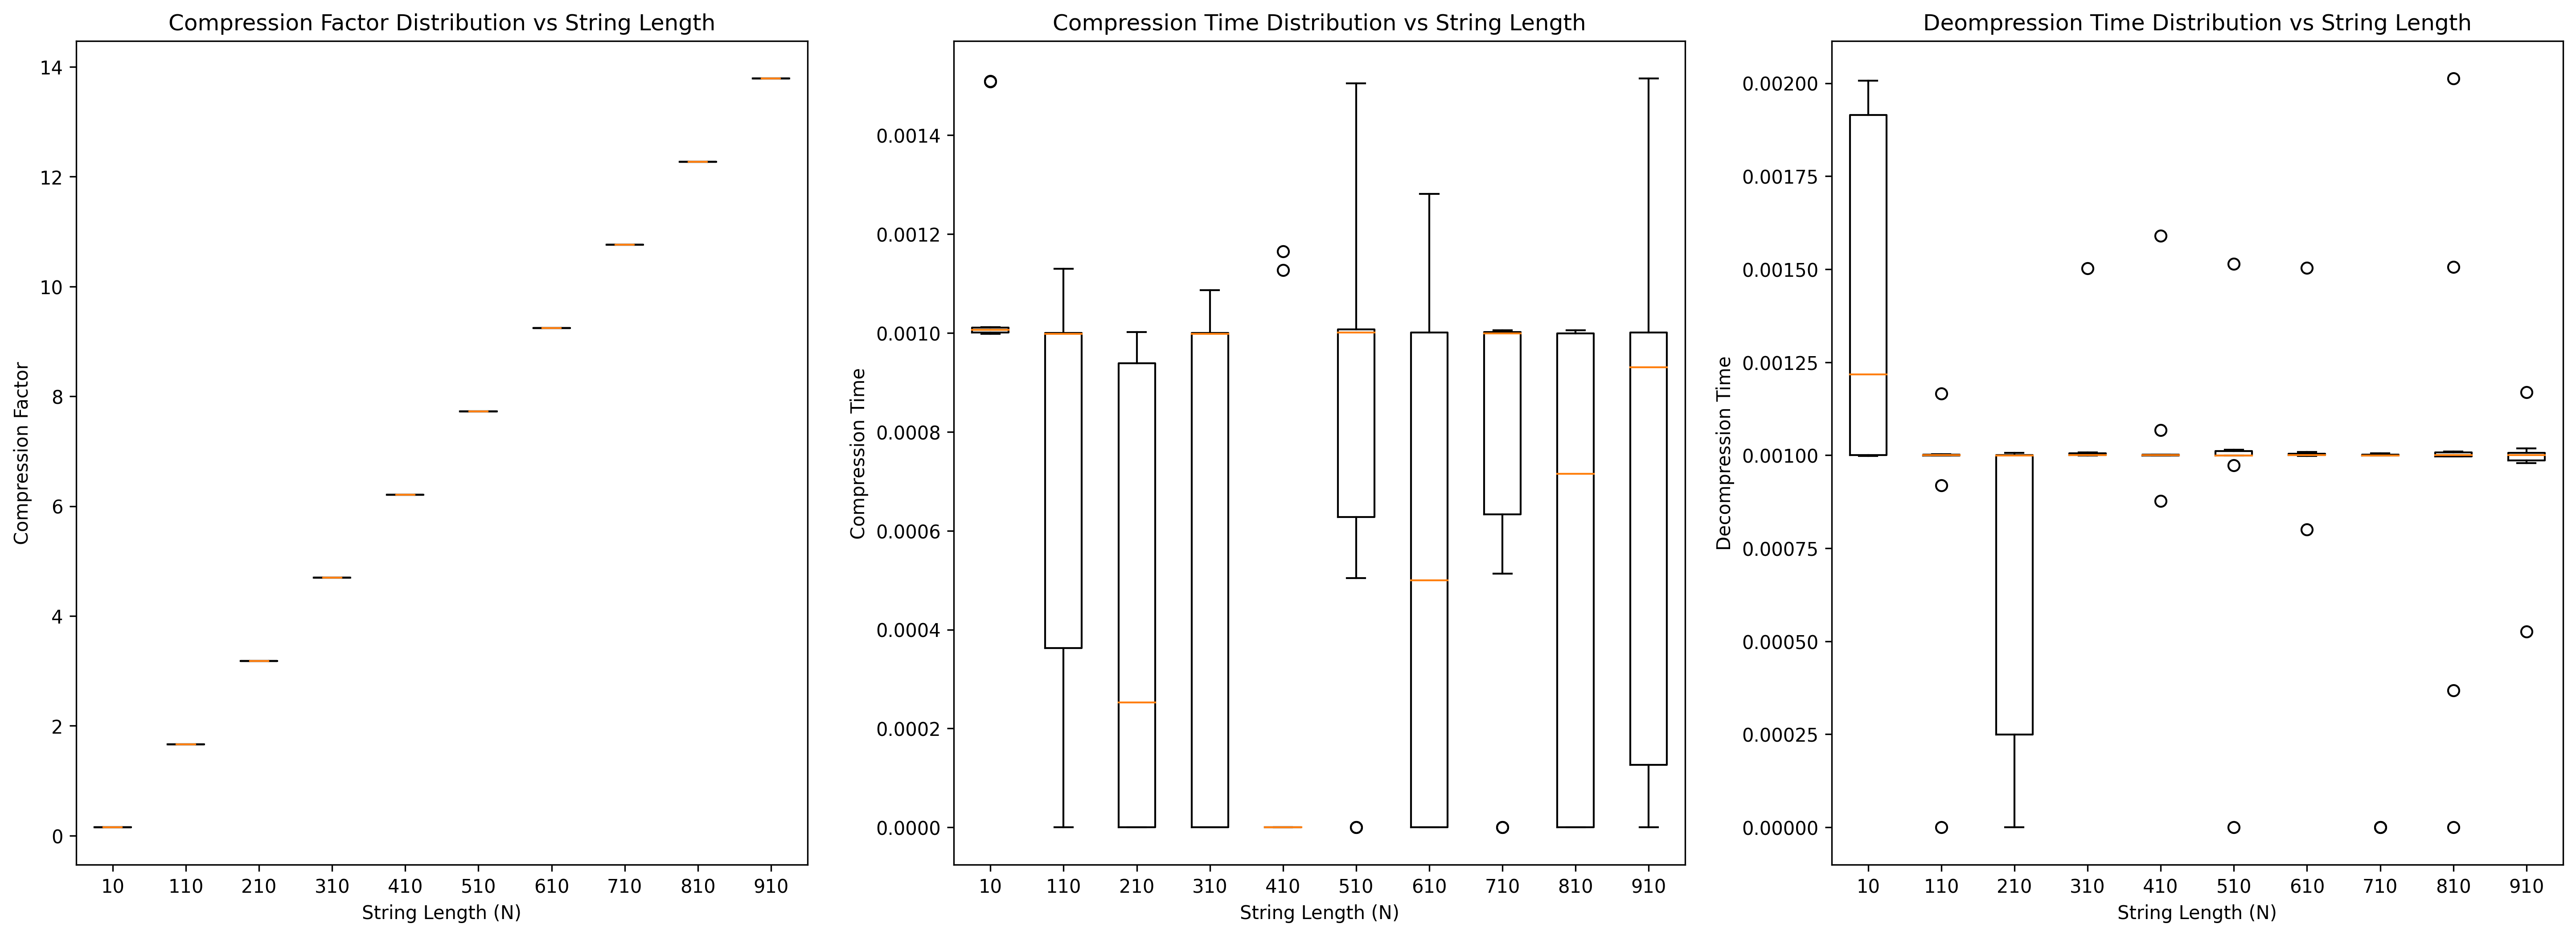

In [433]:
# Create box plot
plt.figure(figsize=(24, 8), dpi=300)

plt.subplot(1, 3, 1)
plt.boxplot(CF.values(), notch=True, labels=N)
plt.xlabel('String Length (N)')
plt.ylabel('Compression Factor')
plt.title('Compression Factor Distribution vs String Length')


plt.subplot(1, 3, 2)
plt.boxplot(t_compress.values(), labels=N)
plt.xlabel('String Length (N)')
plt.ylabel('Compression Time')
plt.title('Compression Time Distribution vs String Length')

plt.subplot(1, 3, 3)
plt.boxplot(t_decompress.values(), labels=N)
plt.xlabel('String Length (N)')
plt.ylabel('Decompression Time')
plt.title('Deompression Time Distribution vs String Length')

## Dataset-2: Olivetti Faces

In [434]:
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState

rng = RandomState(0)

faces, _ = fetch_olivetti_faces(return_X_y=True,
                                shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Dataset
X = faces

In [435]:
X.shape

(400, 4096)

In [436]:
def quantize(img):

    # Normalize pixel values to [0, 255]
    img = 255 * (img - img.min()) / (img.max() - img.min())
    
    # Convert to 8-bit unsigned integer
    img = img.astype(np.uint8)  # Converts to bmp format

    # Convert to string by mapping each pixel value to ASCII character
    img_string = ''.join([chr(int(x)) for x in img.flatten()])

    return img, img_string

In [437]:
img, img_string = quantize(X[0])
# Save the image array as a BMP file
plt.imsave('image.bmp', img.reshape(64, 64), cmap='gray')

In [438]:

def image_encoder(img, file_path="compressed_file.huf"):
    """
    Encodes an 8-bit image using Huffman encoding and saves it to a binary file.
    Args:
        img (numpy.ndarray): Input image in 8-bit format (values 0-255)
        file_path (str, optional): Path where the compressed file will be saved. 
                                 Defaults to "compressed_file.huf"
    Returns:
        None
    File Format:
        The compressed file contains:
        1. Traversal length (2 bytes): Length of the Huffman tree inorder traversal
        2. Traversal padding (1 byte): Number of padding bits for tree traversal
        3. Tree traversal: Encoded Huffman tree structure
        4. Bitstream padding (1 byte): Number of padding bits for compressed data
        5. Compressed bitstream: Huffman-encoded pixel data
    Notes:
        - The image is first flattened and converted to a string of characters
        - A Huffman tree is built based on pixel frequency
        - The tree structure is encoded and stored along with the compressed data
        - Padding is added to ensure byte-alignment in the output file
    """
    # Convert the image array into a flattened list of bytes
    img_flattened = img.flatten().tolist()

    # Convert byte values (0-255) into a string of characters
    img_string = ''.join(chr(pixel) for pixel in img_flattened)

    X = list(img_string)
    symbols_X = set(X)
    symbols_X = list(symbols_X)

    symbol_prob = find_symbol_probability(symbols_X, X)
    symbol_prob = dict(
        sorted(symbol_prob.items(), key=lambda x: x[1], reverse=True))

    huffman_root = build_huffman_tree(symbol_prob)
    traversal = encode_tree(huffman_root)

    bit_one = len(traversal)

    huffman_codes = get_huffman_codes(huffman_root)
    X_bitstream = ''.join(huffman_codes[symbol] for symbol in X)

    with open(file_path, "wb") as file:
        # Write traversal length (number of bits)
        file.write(struct.pack("H", bit_one))  # Store traversal length as 2 bytes

        # Convert traversal into a bitarray
        traversal_bits = bitarray(traversal)

        # Calculate padding to make traversal byte-aligned
        traversal_padding = (8 - len(traversal_bits) % 8) % 8
        traversal_bits.extend('0' * traversal_padding)  # Add extra 0s if needed

        # Write the traversal padding info (so decoder knows how many bits to remove)
        file.write(struct.pack("B", traversal_padding))  # Store 1 byte of padding info

        # Write the traversal itself
        traversal_bits.tofile(file)

        # Convert the bitstream string to a bitarray
        bit_array = bitarray(X_bitstream)
        bitstream_padding = (8 - len(bit_array) % 8) % 8
        bit_array.extend('0' * bitstream_padding)  # Add padding bits

        # Write bitstream padding
        file.write(struct.pack("B", bitstream_padding))  # Store 1 byte of padding info

        # Write the bitstream itself
        bit_array.tofile(file)
    
    return

def image_decoder(file_path="compressed_file.huf"):
    """
    Decodes a Huffman-compressed image file back to its original 8-bit format.
    Args:
        file_path (str, optional): Path to the compressed file. 
                                 Defaults to "compressed_file.huf"
    Returns:
        numpy.ndarray: Decoded image array in 8-bit format (values 0-255)

    Process:
        1. Reads the compressed file header information
        2. Reconstructs the Huffman tree from the stored traversal
        3. Decodes the compressed bitstream using the reconstructed tree
        4. Converts the decoded symbols back to pixel values
    Notes:
        - The function expects the file format created by image_encoder
        - Handles padding removal for both tree traversal and compressed data
        - Returns a flat array that needs to be reshaped to original dimensions
    
    """
    with open(file_path, "rb") as file:
        # Read traversal length (in bits)
        traversal_length = struct.unpack("H", file.read(2))[0]

        # Read traversal padding (so we remove it correctly)
        traversal_padding = struct.unpack("B", file.read(1))[0]

        # Read the traversal bitarray
        traversal = bitarray()
        traversal.frombytes(file.read((traversal_length + traversal_padding + 7) // 8))  # Read full bytes
        traversal = traversal[:traversal_length]  # Remove extra padding bits

        # Read bitstream padding
        bitstream_padding = struct.unpack("B", file.read(1))[0]

        # Read the bitstream bitarray
        X_bitstream = bitarray()
        X_bitstream.fromfile(file)
        if bitstream_padding > 0:
            X_bitstream = X_bitstream[:-bitstream_padding]  # Trim extra padding bits

    huffman_root, _ = decode_tree(traversal, 0)
    huffman_codes = get_huffman_codes(huffman_root)

    # Reverse the huffman_codes dictionary for decoding
    decode_dict = {code: symbol for symbol, code in huffman_codes.items()}

    # Initialize variables for decoding
    decoded_text = []
    current_code = ''

    # print(len(X_bitstream))
    # Process each bit in the bitstream
    for bit in X_bitstream:
        current_code += str(int(bit))

        # Check if current code matches any in our decode dictionary
        if current_code in decode_dict:
            decoded_text.append(decode_dict[current_code])
            current_code = ''

    # Join the decoded symbols into a string
    decoded_text = ''.join(decoded_text)
    # Convert characters back to pixel values (0-255)
    img_array = np.array([ord(char)
                         for char in decoded_text], dtype=np.uint8)

    # print(f"Decoded Text: {decoded_text}")
    return img_array

In [439]:
image_encoder(img, file_path='compressed_img.huf')

In [440]:
recon_img = image_decoder('compressed_img.huf')

MSE: 0.0


Text(0.5, 1.0, 'Reconstructed Image')

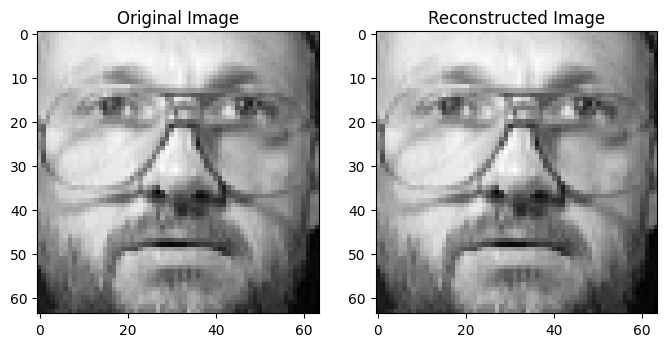

In [441]:
plt.figure(figsize=(8, 6))

print(f"MSE: {np.mean((img-recon_img)**2)}")
plt.subplot(1, 2, 1)
plt.imshow(img.reshape(64, 64), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(recon_img.reshape(64, 64), cmap='gray')
plt.title('Reconstructed Image')

In [442]:
MSE = []
CF = []
t_compress = []
t_decompress = []
for x in X:

    img, img_string = quantize(x)
    plt.imsave('image.bmp', img.reshape(64, 64), cmap='gray')

    t1 = time.time()
    image_encoder(img, file_path='compressed_img.huf')
    t2 = time.time()
    t_compress.append(t2 - t1)

    t1 = time.time()
    recon_img = image_decoder(file_path='compressed_img.huf')
    t2 = time.time()
    t_decompress.append(t2 - t1)

    MSE.append(np.mean((img - recon_img)**2))
    CF.append(compression_factor('image.bmp', 'compressed_img.huf'))

Text(0.5, 1.0, 'Distribution of Decompression Time')

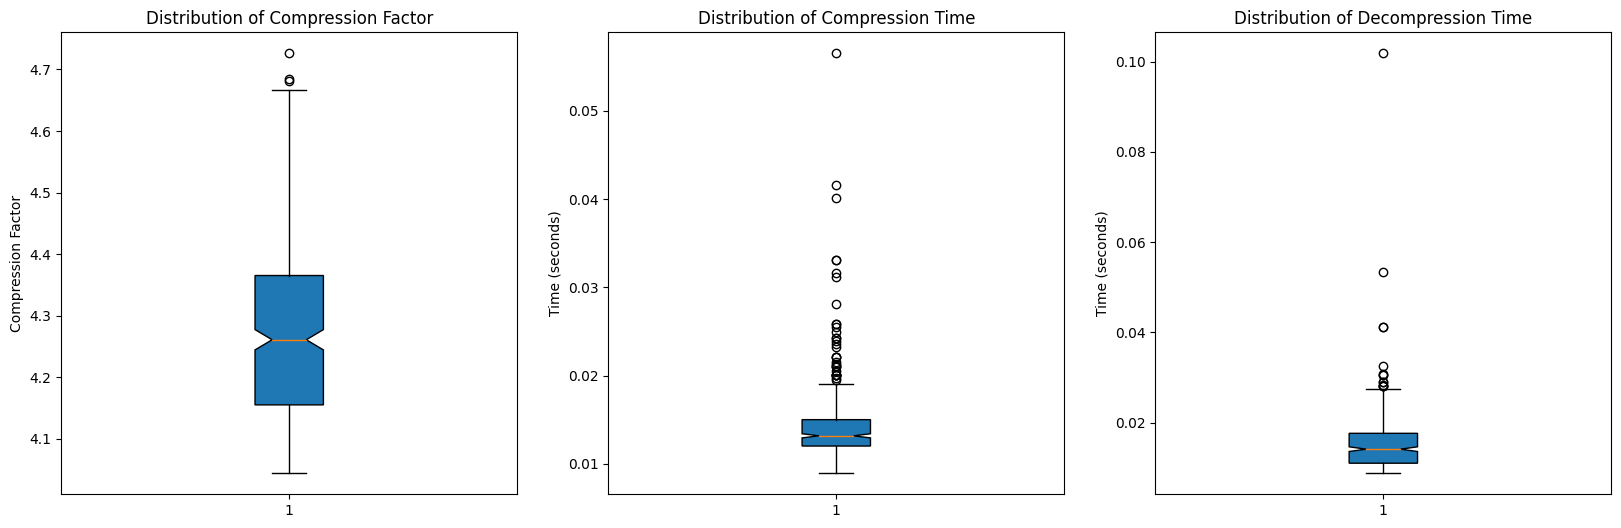

In [443]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.boxplot(CF, notch=True, patch_artist=True)
plt.ylabel('Compression Factor')
plt.title('Distribution of Compression Factor')


plt.subplot(1, 3, 2)
plt.boxplot(t_compress, notch=True, patch_artist=True)
plt.ylabel('Time (seconds)')
plt.title('Distribution of Compression Time')

plt.subplot(1, 3, 3)
plt.boxplot(t_decompress, notch=True, patch_artist=True)
plt.ylabel('Time (seconds)')
plt.title('Distribution of Decompression Time')

Text(0.5, 1.0, 'Distribution of Decompression Time')

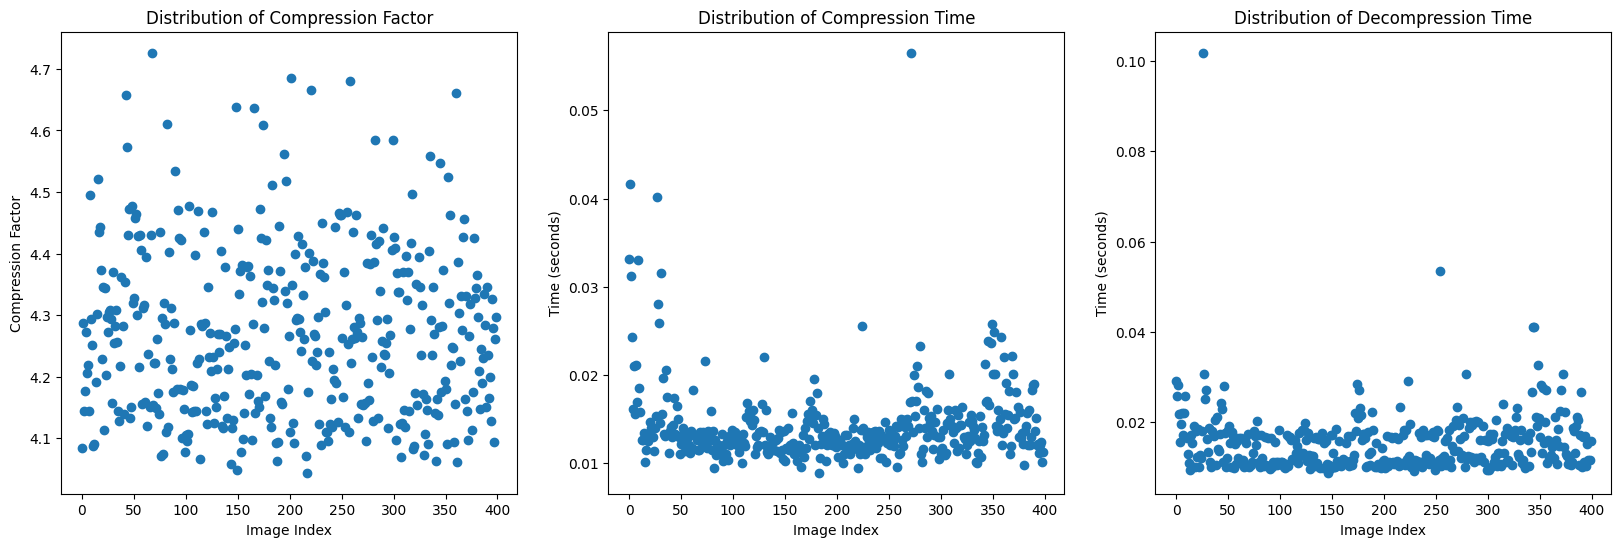

In [444]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.scatter(np.arange(len(CF)), CF)
plt.ylabel('Compression Factor')
plt.xlabel('Image Index')
plt.title('Distribution of Compression Factor')

plt.subplot(1, 3, 2)
plt.scatter(np.arange(len(t_compress)), t_compress)
plt.ylabel('Time (seconds)')
plt.xlabel('Image Index')
plt.title('Distribution of Compression Time')

plt.subplot(1, 3, 3)
plt.scatter(np.arange(len(t_decompress)), t_decompress)
plt.ylabel('Time (seconds)')
plt.xlabel('Image Index')
plt.title('Distribution of Decompression Time')